Running inference...
[==================================================] 100%
Posterior parameter estimates:
Initial P: Mean = 0.4953, HDI = [0.3456, 0.7511]
Prevalence: Mean = 0.3425, HDI = [0.2407, 0.4992]
Imbalance: Mean = 0.8282, HDI = [0.7173, 0.9886]
Migration Time: Mean = 0.5529, HDI = [0.3157, 0.8720]


C:\Users\kypra\AppData\Local\Temp\ipykernel_43220\658588695.py:191: RuntimeWarning: Mean of empty slice
  means_b = np.nanmean(loc_b_data, axis=0)


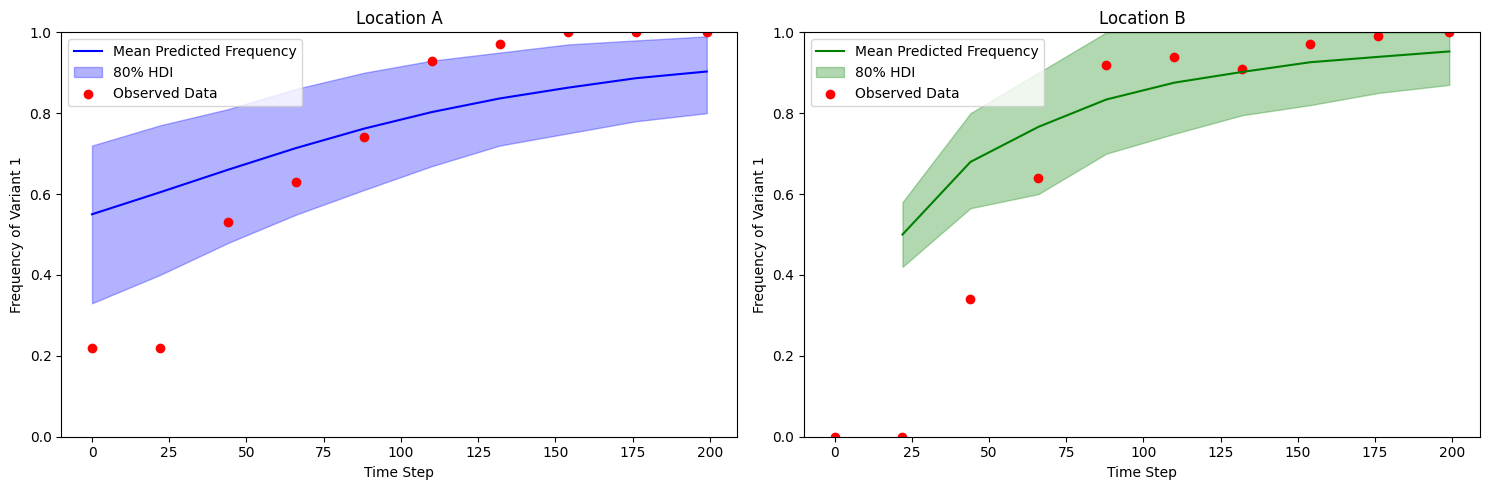

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from arviz import hdi
from sklearn.metrics import mean_squared_error as mse
import sys

def progress_bar(i, max_i, length=50):
    progress = (i + 1) / max_i
    bar_length = int(length * progress)
    bar = '=' * bar_length + '-' * (length - bar_length)
    sys.stdout.write(f'\r[{bar}] {int(progress * 100)}%')
    sys.stdout.flush()

class Agent:
    def __init__(self, variant):
        self.variant = variant
    def change_variant(self):
        if self.variant == 0:
            self.variant = 1
        else:
            self.variant = 0

class Model:
    def __init__(self, agent, size, init_p):
        self.agent = agent
        self.size = size
        self.init_p = init_p

    def populate(self):
        arr = []
        arr_loc = []
        for i in range(np.round(self.size*self.init_p).astype('int')):
            arr.append(self.agent(1))
            arr_loc.append(0)
        for i in range(self.size-len(arr)):
            arr.append(self.agent(0))
            arr_loc.append(0)
        return arr, arr_loc

    def get_variants(self, surface):
        return [x.variant for x in surface]

    def run(self, num_iter, prevalence, imbalance, migtime, birthrate=1.0):
        self.surface, self.location = self.populate()
        self.updatelist = [x for x in range(self.size)]
        self.updatelist2 = [x for x in range(self.size)]
        self.updatelist_2 = []
        self.updatelist2_2 = []
        self.surface2 = []
        self.record = []

        zero_one = prevalence*imbalance
        one_zero = prevalence*(1-imbalance)
        for tick in range(num_iter):
            random.shuffle(self.updatelist)
            random.shuffle(self.updatelist2)
            for idx, updateind in enumerate(self.updatelist):
                if self.surface[updateind].variant == 0 and self.surface[self.updatelist2[idx]].variant == 1 and random.random() < zero_one:
                        self.surface[updateind].change_variant()
                elif self.surface[updateind].variant == 1 and self.surface[self.updatelist2[idx]].variant == 0 and random.random() < one_zero:
                        self.surface[updateind].change_variant()

            if tick == int(np.round(migtime*num_iter)):
                chosen = np.random.choice(a=self.updatelist, size=10)
                self.updatelist_2 = [x for x in range(10)]
                self.updatelist2_2 = [x for x in range(10)]
                for ichosen in chosen:
                    self.surface2.append(self.agent(self.surface[ichosen].variant))

            if len(self.surface2) > 1:
                random.shuffle(self.updatelist_2)
                random.shuffle(self.updatelist2_2)
                for idx, updateind in enumerate(self.updatelist_2):
                    if idx < len(self.updatelist2_2):  # Check to avoid index errors
                        if self.surface2[updateind].variant == 0 and self.surface2[self.updatelist2_2[idx]].variant == 1 and random.random() < zero_one:
                                self.surface2[updateind].change_variant()
                        elif self.surface2[updateind].variant == 1 and self.surface2[self.updatelist2_2[idx]].variant == 0 and random.random() < one_zero:
                                self.surface2[updateind].change_variant()

            if 0 < len(self.surface2) <= self.size:
                random.shuffle(self.updatelist_2)
                tmpcopy = self.updatelist_2.copy()
                for idx, updateind in enumerate(tmpcopy):
                    if random.random() < birthrate and len(self.surface2) < self.size:
                        self.surface2.append(self.agent(self.surface2[updateind].variant))
                        self.updatelist_2.append(max(self.updatelist_2) + 1 if self.updatelist_2 else 0)
                        self.updatelist2_2.append(max(self.updatelist2_2) + 1 if self.updatelist2_2 else 0)

            metric1 = np.mean(self.get_variants(self.surface))
            metric2 = np.mean(self.get_variants(self.surface2)) if len(self.surface2) > 0 else -1
            self.record.append([metric1, metric2])

        return self.record

    def lossfunc(self, data_a, data_b, preds):
        # Convert predictions to numpy arrays
        preds_a = np.array([p[0] for p in preds])
        preds_b = np.array([p[1] if p[1] >= 0 else 0 for p in preds])
        
        # Calculate MSE for location A
        loss_a = mse(preds_a, data_a)
        
        # Only use B data where we have predictions (after migration)
        migration_occurred = any(p[1] >= 0 for p in preds)
        if migration_occurred:
            # Find the first time B has values
            first_b_idx = next((i for i, p in enumerate(preds) if p[1] >= 0), len(preds))
            
            # Calculate MSE for location B only after migration
            if first_b_idx < len(data_b):
                valid_b_data = data_b[first_b_idx:]
                valid_b_preds = preds_b[first_b_idx:first_b_idx + len(valid_b_data)]
                loss_b = mse(valid_b_preds, valid_b_data)
            else:
                loss_b = 0
        else:
            loss_b = 0
        
        # Combine losses - weight them equally
        return loss_a + loss_b

    def inference(self, data, n_runs, priors):
        self.samples = []
        self.samplescore = []
        self.params = []
        
        # Extract data
        timesteps = data['X'].to_numpy()
        data_a = data['A'].to_numpy()
        data_b = data['B'].to_numpy()
        
        # Unpack priors
        init_p_prior, prevalence_prior, imbalance_prior, migtime_prior = priors
        
        for run in range(n_runs):
            progress_bar(run, n_runs)
            
            # Sample parameters from priors
            init_p_chosen = random.choice(init_p_prior)
            prevalence_chosen = random.choice(prevalence_prior)
            imbalance_chosen = random.choice(imbalance_prior)
            migtime_chosen = random.choice(migtime_prior)
            
            # Update initial probability
            self.init_p = init_p_chosen
            
            # Run simulation
            preds = self.run(len(timesteps), prevalence_chosen, imbalance_chosen, migtime_chosen)
            
            # Store results
            self.samples.append(np.asarray(preds))
            self.samplescore.append(self.lossfunc(data_a, data_b, preds))
            self.params.append(np.asarray([init_p_chosen, prevalence_chosen, imbalance_chosen, migtime_chosen]))

    def postsummary(self, percentile, ci):
        accepted_idx = np.where(self.samplescore < np.percentile(self.samplescore, percentile))[0]
        self.accepted_params = np.asarray([x for i, x in enumerate(self.params) if i in accepted_idx])
        self.accepted_samples = [x for i, x in enumerate(self.samples) if i in accepted_idx]
        self.accepted_samplescores = [x for i, x in enumerate(self.samplescore) if i in accepted_idx]
        
        self.hdis = []
        self.parammeans = []
        
        # Parameter names for better output
        param_names = ["Initial P", "Prevalence", "Imbalance", "Migration Time"]
        
        for i in range(np.shape(self.params)[1]):
            self.hdis.append(hdi(self.accepted_params[:,i], ci))
            self.parammeans.append(np.mean(self.accepted_params[:,i]))
            print(f"{param_names[i]}: Mean = {self.parammeans[i]:.4f}, HDI = [{self.hdis[i][0]:.4f}, {self.hdis[i][1]:.4f}]")
            
        return self.parammeans, self.hdis

    def plot_results(self, data):
        timesteps = data['X'].to_numpy()
        
        # Stack all accepted samples
        stacked_samples = np.stack(self.accepted_samples)
        
        # Calculate means and HDIs for location A
        means_a = np.mean(stacked_samples[:, :, 0], axis=0)
        lower_a = np.array([np.percentile(stacked_samples[:, t, 0], 10) for t in range(stacked_samples.shape[1])])
        upper_a = np.array([np.percentile(stacked_samples[:, t, 0], 90) for t in range(stacked_samples.shape[1])])
        
        # Calculate means and HDIs for location B, handling -1 values
        # Replace -1 with NaN for plotting
        loc_b_data = stacked_samples[:, :, 1].copy()
        loc_b_data[loc_b_data < 0] = np.nan
        means_b = np.nanmean(loc_b_data, axis=0)
        lower_b = np.array([np.nanpercentile(loc_b_data[:, t], 10) if not np.all(np.isnan(loc_b_data[:, t])) else np.nan 
                            for t in range(loc_b_data.shape[1])])
        upper_b = np.array([np.nanpercentile(loc_b_data[:, t], 90) if not np.all(np.isnan(loc_b_data[:, t])) else np.nan 
                            for t in range(loc_b_data.shape[1])])
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Location A
        ax1.plot(timesteps, means_a, color='blue', label='Mean Predicted Frequency')
        ax1.fill_between(timesteps, lower_a, upper_a, alpha=0.3, color='blue', label='80% HDI')
        ax1.scatter(timesteps, data['A'], color='red', label='Observed Data')
        ax1.set_title('Location A')
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Frequency of Variant 1')
        ax1.legend()
        ax1.set_ylim(0, 1)
        
        # Location B
        ax2.plot(timesteps, means_b, color='green', label='Mean Predicted Frequency')
        ax2.fill_between(timesteps, lower_b, upper_b, alpha=0.3, color='green', label='80% HDI')
        ax2.scatter(timesteps, data['B'], color='red', label='Observed Data')
        ax2.set_title('Location B')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Frequency of Variant 1')
        ax2.legend()
        ax2.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()

# Main code to run the simulation
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Load data
    df = pd.read_csv("assignment_data.csv")
    
    # Initialize model - the initial p will be overridden during inference
    mymodel = Model(Agent, 100, 0.5)  
    
    # Define priors for parameters
    init_p_prior = np.random.uniform(0.01, 0.99, 10000)
    prevalence_prior = np.random.uniform(0.01, 0.5, 10000)
    imbalance_prior = np.random.uniform(0.01, 0.99, 10000)
    migtime_prior = np.random.uniform(0.1, 0.9, 10000)
    
    priors = [init_p_prior, prevalence_prior, imbalance_prior, migtime_prior]
    
    # Run inference
    print("Running inference...")
    mymodel.inference(df, 5000, priors)  # 5000 runs to get good estimates
    
    # Get posterior summary
    print("\nPosterior parameter estimates:")
    mymodel.postsummary(10, 0.8)  # Keep top 10% of samples, 80% HDI
    
    # Plot results
    mymodel.plot_results(df)